In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from collections import Counter
from torchinfo import summary
from gem.models import CNN
from sklearn import preprocessing

original_seq = 'atcccgggtgaggcatcccaccatcctcagtcacagagagacccaatctaccatcagcatcagccagtaaagattaagaaaaacttagggtgaaagaaatttcacctaacacggcgca'
original_seq=original_seq.upper()
prefix,suffix = original_seq[:72],original_seq[96:]
name,seq_len,suff = "pl3-1-2",118,"" # pl3-1-2, "core6-merge
kernel_size = 5
tlp = "/data/home/jinyalong/git/txdas/biotech/notebook/SEV_Promoter"
fn = f"{tlp}/models/{name}-{kernel_size}.pt"
model = CNN(kernel_size=kernel_size, seq_len=seq_len)
model.load_state_dict(torch.load(fn,weights_only=True))
datadir=f"/data/home/jinyalong/data/sev_240624/results"
# datadir=f"/data/home/jinyalong/data/sev_241023/results"
df = pd.read_csv(f"{datadir}/{name}/{name}_final.csv")
scaler = preprocessing.StandardScaler()
scaler.fit_transform(df.loc[:,"score"].values.reshape(-1,1))

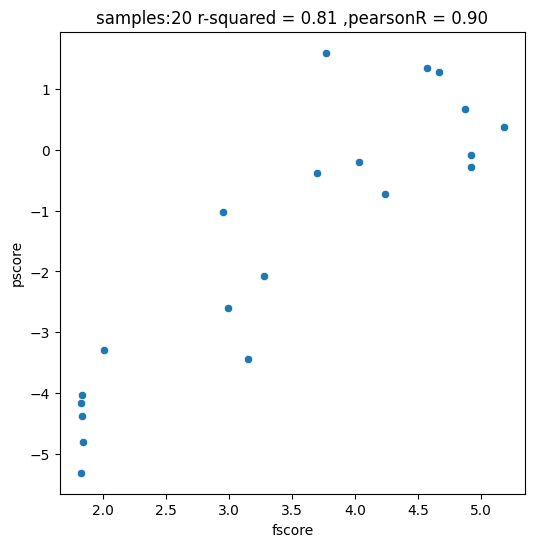

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from gem.encode import Tokenizer
from sklearn import preprocessing

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

datadir=f"/data/home/jinyalong/data/sev_240624/results"
datadir=f"/data/home/jinyalong/data/sev_241023/results"
df = pd.read_csv(f"{datadir}/{name}/{name}_final.csv")
scaler = preprocessing.StandardScaler()
scaler.fit_transform(df.loc[:,"score"].values.reshape(-1,1))
fdf = pd.read_csv(f"/data/home/jinyalong/data/sev_240624/results/fscore5d.csv",
                  names=["index","seq","length", "distance","fscore"],sep="\t")
# fdf.loc[20]=[21,original_seq[72:96],24,0,1181]
# fdf = pd.read_csv(f"/data/home/jinyalong/data/sev_240624/results/fscore11d.csv",
#                   names=["index","seq","gfp1", "gfp2","fscore"],sep="\t")
# fdf.loc[30]=["WT",original_seq[72:96],264,150,207]
fdf["seq"]= fdf.seq.apply(lambda x:prefix+x+suffix)
token = Tokenizer()
onehot_data = token.encode(fdf["seq"],seq_len=seq_len)
scores = model(torch.tensor(onehot_data).float())
fdf["pscore"]= scaler.inverse_transform(scores.detach().numpy())
fdf["fscore"] = np.log(fdf["fscore"])
sdf=fdf
num=len(sdf)
values = np.vstack([sdf['fscore'],sdf["pscore"]])
kernel = stats.gaussian_kde(values)(values)
fig, ax = plt.subplots(figsize=(6, 6))
r = r2(sdf["pscore"],sdf["fscore"])
pr =  stats.pearsonr(sdf["fscore"],sdf["pscore"])
plt.title(f"samples:{num} r-squared = {r:.2f} ,pearsonR = {pr[0]:.2f}")
splot=sns.scatterplot(data=sdf,x="fscore", y="pscore")

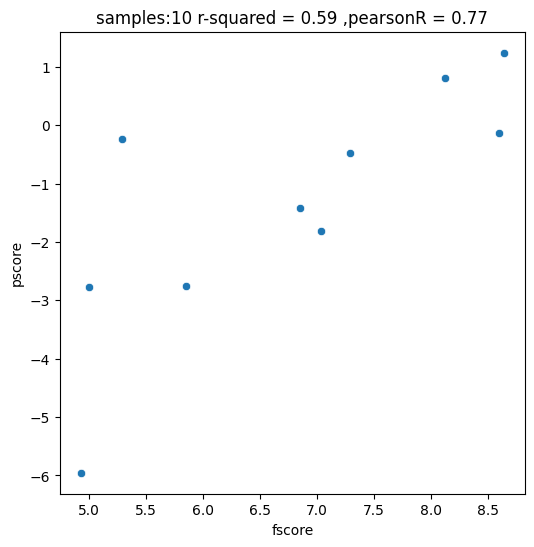

In [117]:
with open('./data/sev118_10.txt') as fh:
    designed = [i.strip().upper() for i in fh.read().split()]
designed = {n: s for n, s in zip(['1', '3', '6', '10', '14', '24', '31', '37', '39', 'WT'], designed)}
designed_expr = {'WT': 5619, '1': 5400, '6': 3375.5, '37': 1462, '14': 1130.5, '10': 942, '24': 347.5, '39': 198.5, '31': 149, '3': 138.5}
edf = pd.DataFrame(data={"label":designed.keys(),"seq":designed.values()})
edf["fscore"] = edf["label"].apply(lambda x:designed_expr.get(x))
onehot_data = token.encode(edf["seq"],seq_len=seq_len)
scores = model(torch.tensor(onehot_data).float())
edf["pscore"]= scaler.inverse_transform(scores.detach().numpy())
edf["fscore"] = np.log(edf["fscore"])
sdf=edf
num=len(sdf)
values = np.vstack([sdf['fscore'],sdf["pscore"]])
kernel = stats.gaussian_kde(values)(values)
fig, ax = plt.subplots(figsize=(6, 6))
r = r2(sdf["pscore"],sdf["fscore"])
pr =  stats.pearsonr(sdf["fscore"],sdf["pscore"])
plt.title(f"samples:{num} r-squared = {r:.2f} ,pearsonR = {pr[0]:.2f}")
splot=sns.scatterplot(data=sdf,x="fscore", y="pscore")

In [112]:
import pandas  as pd
import pybktree
import Levenshtein
import tqdm
from collections import Counter
trg = "/data/home/jinyalong/data/sev_3gene"
df = pd.read_csv(f"{trg}/gn.csv")
sdf = pd.read_csv(f"{trg}/promoters.csv")
tree = pybktree.BKTree(Levenshtein.distance, sdf["seq"].drop_duplicates())
name,column,fname ="Amix-1", "EGFP","Gmix_score" #EGFP TagBFP,mCherry
gdf = pd.read_csv(f"/data/home/jinyalong/data/facs-seq/{name}_score.csv").rename(columns={"seq":"barcode"})
gdf = gdf.sort_values("total",ascending=False)[:200]
gtree = pybktree.BKTree(Levenshtein.distance, df["barcode"].drop_duplicates())

def match(seq,tree, max_distance=15):
    ret = tree.find(seq,max_distance)
    if len(ret)>0:
        distance,seq = ret[0][0],ret[0][1]
        return pd.Series([distance,seq])
    else:
        return pd.Series([1000, ""])


tqdm.tqdm.pandas(desc=f"mapping 3rd_seq[{column}] to lib")
df[[f"{column}_distance",f"{column}_seq"]] = df[column].progress_apply(lambda x: match(x,tree))
print(df[f"{column}_distance"].value_counts())
tqdm.tqdm.pandas(desc=f"mapping barcode to flow data[{name}]")
gdf[["barcode_distance","mbarcode"]] = gdf["barcode"].progress_apply(lambda x: match(x,gtree,max_distance=15))
print(gdf["barcode_distance"].value_counts())
df = df[[f"{column}_seq","barcode","blen","slen",f"{column}_distance"]].drop_duplicates().rename(columns={f"{column}_seq":"seq","barcode":"mbarcode"})
mdf = gdf.merge(df)
mdf = mdf.merge(sdf)
cdf =  mdf.groupby("barcode")["seq"].nunique().to_frame("seqn").reset_index()
mdf = mdf.merge(cdf)
mdf

mapping 3rd_seq[EGFP] to lib: 100%|██████████| 44858/44858 [00:05<00:00, 8679.18it/s] 


EGFP_distance
0       11370
5        4563
1        4398
6        4296
4        4263
3        4202
2        3685
7        3225
8        2311
9        1331
10        732
11        279
12        134
13         43
14         16
1000        6
15          4
Name: count, dtype: int64


mapping barcode to flow data[Amix-1]: 100%|██████████| 200/200 [00:07<00:00, 25.19it/s]


barcode_distance
1    104
0     52
4     18
3     13
5      9
2      4
Name: count, dtype: int64


,Unnamed: 0,barcode,total,Gmix_score,Bmix_score,Rmix_score,barcode_distance,mbarcode,seq,blen,slen,EGFP_distance,sid,qtype,pscore,seqn
0,303,ATAAAGCACACCCGTGCATA,4666503.0,8.730501,7.598392,7.165735,0,ATAAAGCACACCCGTGCATA,AACCGGGGTGAGGCATTACACCATCCTAAGTCACAGAGAGATCCAA...,20,115,8,1,high,2.075271,3
1,303,ATAAAGCACACCCGTGCATA,4666503.0,8.730501,7.598392,7.165735,0,ATAAAGCACACCCGTGCATA,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,20,118,0,14,median,-2.092124,3
2,303,ATAAAGCACACCCGTGCATA,4666503.0,8.730501,7.598392,7.165735,0,ATAAAGCACACCCGTGCATA,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,20,117,4,WT,high,1.902128,3
3,303,ATAAAGCACACCCGTGCATA,4666503.0,8.730501,7.598392,7.165735,0,ATAAAGCACACCCGTGCATA,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,20,118,2,WT,high,1.902128,3
4,333,ATAAATCACACCCGTGCATA,3417.0,5.823008,7.499033,7.641631,1,ATAAAGCACACCCGTGCATA,AACCGGGGTGAGGCATTACACCATCCTAAGTCACAGAGAGATCCAA...,20,115,8,1,high,2.075271,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,1013,TTACCTCATACGAAATCACA,844.0,5.107655,6.000953,5.719794,3,ATACTCATACGAATCACA,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,18,118,0,31,low,-2.595063,1
360,651,CTACTTCATACGAAATCACA,315.0,5.076579,6.353799,5.627442,3,ATACTCATACGAATCACA,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,18,118,0,31,low,-2.595063,1
361,658,CTATCTCATACGAAATCACA,297.0,5.396083,5.916490,5.692085,3,ATACTCATACGAATCACA,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,18,118,0,31,low,-2.595063,1
362,283,ATAAAGAATTGTATTCCATT,202.0,5.991242,5.287020,6.884554,5,ATAGAAATTATATTGCATAT,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,20,122,8,31,low,-2.595063,1


In [1]:
medf =edf.rename(columns={"label":"sid"})[["sid","fscore","pscore"]]
sdf = medf.merge(mdf[["sid","Gmix_score","Rmix_score","Bmix_score"]])
sdf = sdf.groupby("sid")[["fscore",fname]].mean()
r = r2(sdf[fname],sdf["fscore"])
pr =  stats.pearsonr(sdf["fscore"],sdf[fname])
# plt.title(f"{column}: r-squared = {r:.2f} ,pearsonR = {pr[0]:.2f}")
splot=sns.scatterplot(data=sdf,x="fscore", y=fname, color=fname[0].lower())

NameError: name 'edf' is not defined